<a href="https://colab.research.google.com/github/shivammehta007/Information-Retrieval/blob/master/AntispamStatsSeminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Description**

Build distribution charts in spam and non-spam sets of the following features:

1 Number of words per page
2 Average word length
3 Number of words in the page title (words in the <html><head> <title> Some text </title> tag)
4 Number of words in link anchors (<html> <body> <a> Some text </a>)
5 compression ratio

It is necessary to calculate the statistics for at least three signs and be sure to do for the 1st and 2nd signs

And send the first decision to the competition https://kaggle.com/join/antispam_infopoisk
Based on one of the above signs, try to divide the number so that the score in the competition is more than 0.55

If all these conditions are met during the seminar, +1 point to DZ

Description of DZ and the rules for setting points for it at https://inclass.kaggle.com/c/antispam-infopoisk
To specify the terms of DZ with the teacher - usually 2 weeks

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from importlib import reload

In [4]:
from __future__ import division
! pip install ftfy

import base64
import csv
import gzip
import zlib
import ftfy

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

### Utilities

#### Decorators

### What I changed here was the use of ftfy library to fix the text, encoding was latin-1, So i decoded the text and converted into russian characters with ftfy library

In [0]:
def to_utf8(text):
    if isinstance(text, str): text = text.encode("ISO-8859-1")
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, str): text = ftfy.fix_text(text.decode("latin-1"))
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Decorators can complicate debugging, so you can completely discard them and use copy-paste

### Extract text from html

#### Extraction of text using built-in modules

In [0]:
from html.parser import HTMLParser
import re

###Extracting text from title can be entered here

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()
    
    def extract_title(self):
        soup = BeautifulSoup(text)
        if soup.title != None:
            self._title = soup.title.string

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    soup = BeautifulSoup(text)
    title = ""
    if soup.title != None:
        title = soup.title.string
    anchor = ""
    if soup.find('a') != None:
        anchor = soup.find('a').text
        
    return parser.text(), title, anchor

In [0]:
from bs4 import BeautifulSoup

#### Extraction of text using additional libraries

In [0]:
def html2text_bs(raw_html):
    """
    Here is the extraction of text from html
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    """
    Here the text is extracted from the html, which is visible to the user
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    another library that extracts the text that is visible to the user very well,
    but it is tied to java
    """
    pass

#### Choose which method to convert html to text will be the main

In [0]:
#html2text = html2text_bs
html2text = html2text_parser

#### Methods for tokenizing text

In [0]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint so that installing pymorphy2 would not be required
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### The main function that is called to convert html to a list of words

In [0]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    text, title, anchor = to_text(raw_html)
    if title == None:
        title = ""
    if anchor == None:
        anchor = ""
    return tokenizer(text.lower()), tokenizer(title.lower()), tokenizer(anchor.lower())

#### Calculation of final metrics

In [0]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Metric counting function
    Options
    predictions - document rank
    threshold - threshold for metrics
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [0]:
def calc_features(url, html_data):
    words, title, anchor = html2word(html_data)

    anchor = list(anchor)
    words = list(words)
    title = list(title)
    words_num = len(words)
    # print(words, title, anchor)
    
    avg_word_len = 0
    for word in words:
        avg_word_len += len(word)
    avg_word_len = avg_word_len/words_num
    title_words_num = len(title)    
    anchor_words_num = len(anchor)
    compression_level = 0
    
    return [len(words), avg_word_len, title_words_num, anchor_words_num, compression_level, words]

In [15]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
'<html><body><a> Some text </a>'
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print(test_features)

[8, 3.625, 2, 2, 0, ['заголовок', 'ololo', 'спам', '1', '2', '3', 'some', 'text']]


In [0]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features', 'words'])

def load_csv(input_file_name, calc_features_f):    
    """
    We load data and extract signs on the fly
    Content itself is not saved to reduce memory consumption - to
    could run even on laptops in class
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            line = line.decode()
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)      
            yield DocItem(url_id, mark, url, features[:-1], features[-1])            
                
        trace(i, 1)        

** We process the input file **
<br>
Format - fields separated by tabs
<br>
0 - document id
<br>
1 - class label 0 - not spam, 1 - spam
<br>
2 - url of the document
<br>
3 - base64 encoded document
### I Added a fourth returning parameter that will give me all the words in that row
4 - Words

The output format is an array of tuples of the form
(doc_id, is_spam, url, html_data, **words**)

In [0]:
import pandas as pd


In [0]:
import os

In [19]:
os.path.exists('drive/My Drive/Homeworks/InformationRetrieval/hw3/kaggle_test_data_tab_new.csv.gz')

True

In [20]:
%%time

file_location = 'drive/My Drive/Homeworks/InformationRetrieval/hw3/kaggle_train_data_tab_new.csv.gz'
TRAIN_DATA_FILE  = file_location

train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))

12:57:02 INFO:Complete items 00000
12:59:19 INFO:Complete items 01000
13:01:07 INFO:Complete items 02000
13:03:05 INFO:Complete items 03000
13:05:04 INFO:Complete items 04000
13:07:06 INFO:Complete items 05000
13:09:05 INFO:Complete items 06000
13:11:16 INFO:Complete items 07000
13:11:20 INFO:Complete items 07043


CPU times: user 14min 14s, sys: 3.95 s, total: 14min 18s
Wall time: 14min 18s


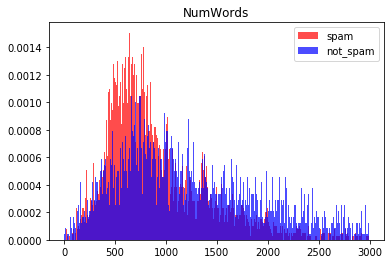

In [21]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

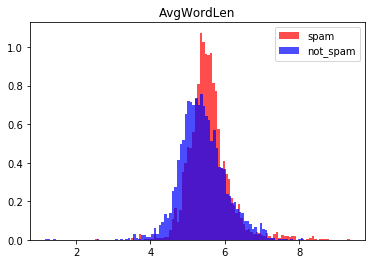

In [22]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


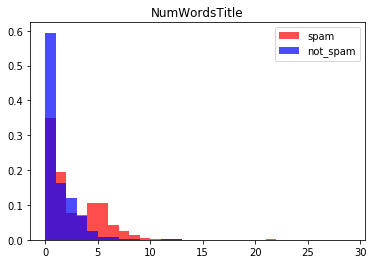

In [23]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

## **Classifier**


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

import numpy as np


In [0]:
train_data = pd.DataFrame(train_docs)
X_train = train_data['words'].apply(' '.join)
y_train = train_data['is_spam'].replace({True: 1, False: 0})

In [0]:
tf = TfidfVectorizer()
X_train = tf.fit_transform(X_train)

In [28]:
X_train.shape, y_train.shape

((7044, 632797), (7044,))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [30]:
models = [MLPClassifier, RandomForestClassifier, SVC]
accuracy = []
trained_models = []
for model in models:
    m = model(verbose=True)
    m.fit(X_train, y_train)
    output = m.predict(X_test)
    acc = accuracy_score(output, y_test)
    print(f'Accuracy : {acc:.4f}%')

    accuracy.append(acc)
    trained_models.append(m)

Iteration 1, loss = 0.54993798
Iteration 2, loss = 0.24809562
Iteration 3, loss = 0.11818287
Iteration 4, loss = 0.06684747
Iteration 5, loss = 0.04301014
Iteration 6, loss = 0.03052526
Iteration 7, loss = 0.02321568
Iteration 8, loss = 0.01871268
Iteration 9, loss = 0.01564856
Iteration 10, loss = 0.01342359
Iteration 11, loss = 0.01184358
Iteration 12, loss = 0.01062684
Iteration 13, loss = 0.00960382
Iteration 14, loss = 0.00882661
Iteration 15, loss = 0.00816573
Iteration 16, loss = 0.00761375
Iteration 17, loss = 0.00717191
Iteration 18, loss = 0.00678036
Iteration 19, loss = 0.00642716
Iteration 20, loss = 0.00612971
Iteration 21, loss = 0.00587121
Iteration 22, loss = 0.00563902
Iteration 23, loss = 0.00541524
Iteration 24, loss = 0.00521820
Iteration 25, loss = 0.00504531
Iteration 26, loss = 0.00487996
Iteration 27, loss = 0.00472899
Iteration 28, loss = 0.00459071
Iteration 29, loss = 0.00445398
Iteration 30, loss = 0.00433535
Iteration 31, loss = 0.00421598
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Accuracy : 0.9461%


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]Accuracy : 0.5919%


In [0]:
best_model = trained_models[0]

In [36]:
%%time
test_file_location = 'drive/My Drive/Homeworks/InformationRetrieval/hw3/kaggle_test_data_tab_new.csv.gz'

TEST_DATA_FILE  = test_file_location

13:56:23 INFO:Complete items 00000
13:59:26 INFO:Complete items 01000
14:02:07 INFO:Complete items 02000
14:04:36 INFO:Complete items 03000
14:06:50 INFO:Complete items 04000
14:09:00 INFO:Complete items 05000
14:11:43 INFO:Complete items 06000
14:14:02 INFO:Complete items 07000
14:16:30 INFO:Complete items 08000
14:18:53 INFO:Complete items 09000
14:22:00 INFO:Complete items 10000
14:24:23 INFO:Complete items 11000
14:26:45 INFO:Complete items 12000
14:28:50 INFO:Complete items 13000
14:31:22 INFO:Complete items 14000
14:34:02 INFO:Complete items 15000
14:36:46 INFO:Complete items 16000
14:36:54 INFO:Complete items 16038


CPU times: user 40min 21s, sys: 8.31 s, total: 40min 29s
Wall time: 40min 31s


## Writing Output

In [81]:
%%time
TEST_DATA_FILE  = test_file_location

test_docs = load_csv(TEST_DATA_FILE, calc_features)


with open('my_submission.csv' , 'w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in test_docs:
        line = ' '.join(item.words)
        line = tf.transform([line])
        prediction = best_model.predict(line)[0]
        writer.writerow([item[0], prediction])

15:16:30 INFO:Complete items 00000
15:19:40 INFO:Complete items 01000
15:22:26 INFO:Complete items 02000
15:25:01 INFO:Complete items 03000
15:27:17 INFO:Complete items 04000
15:29:29 INFO:Complete items 05000
15:32:12 INFO:Complete items 06000
15:34:31 INFO:Complete items 07000
15:36:59 INFO:Complete items 08000
15:39:19 INFO:Complete items 09000
15:42:23 INFO:Complete items 10000
15:44:44 INFO:Complete items 11000
15:47:04 INFO:Complete items 12000
15:49:06 INFO:Complete items 13000
15:51:31 INFO:Complete items 14000
15:54:04 INFO:Complete items 15000
15:56:40 INFO:Complete items 16000
15:56:46 INFO:Complete items 16038


CPU times: user 40min 7s, sys: 5.86 s, total: 40min 13s
Wall time: 40min 15s


In [80]:
pd.read_csv('my_submission.csv')

,Id,Prediction
0,-1109772587479963780,0
1,-1106366422832451997,1
2,-1105668373469654832,0
3,-1105237772827470662,1
4,-1103748450951392672,0
5,-1102576576553740237,1
6,-1101841293250128385,1
